![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import BaggingClassifier

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

La agrupación del total de alquileres por la variable binaria de si es dia laboral, muestra una promedio mayor de alquileres en los dias laborales. Posiblemente el trafico durante estos dias, la cantidad de compromisos o el inicio de actividades en un mayor rango de horario aportan a este promedio mayor

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Los valores mayores de alquiler de bicicletas suceden desde las 7 am y van hasta las 8 pm, donde los valores superan las 200 unidades. Se presentan casos de alquiler incluso en las horas de la madrugada pero en una cantidad mucho menor. El hecho q inicie desde las 7 am los volumenes altos puede soportar el supuesto que la jornada laboral durante los dias laborales aporta al incremento de las unidades 

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

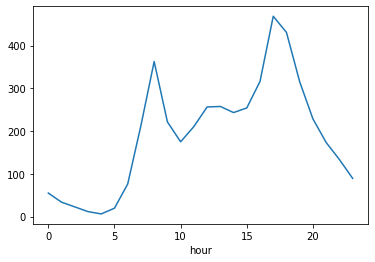

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

El promedio de alquiler agrupado por horas del dia muestra picos a las 8 am y las 6 pm, es unarepresentación grafica de los valores observados anteriormente

<AxesSubplot:xlabel='hour'>

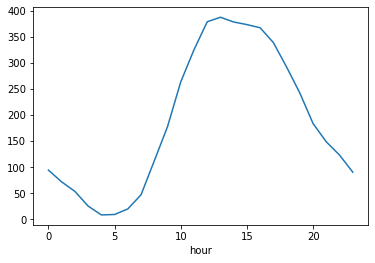

In [7]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes.workingday==0].groupby('hour').total.mean().plot()

Al analizar el promedio de alquiler por horas endías no laborales se presenta una distribución acampanada con media cerca a la 1 pm, estariamos analizando fines de semana donde los picos de 8 am y 6 pm no estan presentes, por el contrario una concentracion de valores entre las 12 pm y 4 pm

<AxesSubplot:xlabel='hour'>

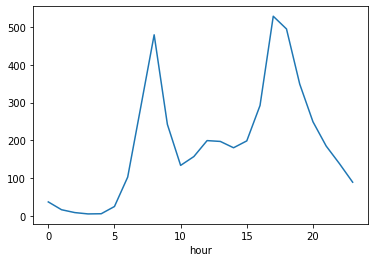

In [8]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes.workingday==1].groupby('hour').total.mean().plot()

Al revisar el promedio de alquiler por hora en dias laborales, vuelven a ser visibles los picos mencionados anteriormente confirmando la importancia de esta variable en el comportamiento de alquileres

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
# Celda 3
X = bikes[["hour","workingday"]]
y = bikes.total
LR = LinearRegression()
LR.fit(X,y)
LR.coef_

array([10.49206282,  4.07248627])

Ambos coeficientes son positivos y presentan valores considerables, en el caso de la hora es la que mayor impacto segun su cambio presenta en el comportamiento de los alquileres, sin embargo el ser o no dia laboral tambien aporta a la explicación de la variacion de las cantidades de alquiler. Una de las desventajas es que la regresión lineal plantea una linea recta para explicar la función del caso y como se ha presentado en celdas anteriores la variación entre horas no es lineal y la variable de dia laboral es binaria lo que dificulta tambien la representación lineal de su relación.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [10]:
# Celda 4
def tasa(y):
    if y.shape[0] == 0:
        return 0
    else:
        #gini = 1 - (y.mean()**2 + (1 - y.mean())**2)
        mse = (np.square(y - y.mean())).mean()
        return mse

def tasa_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    tasa_y = tasa(y)
    tasa_l = tasa(y_l)
    tasa_r = tasa(y_r)
    
    tasa_impurity_ = tasa_y - (n_l / (n_l + n_r) * tasa_l + n_r / (n_l + n_r) * tasa_r)
    
    return tasa_impurity_

def best_split(X, y, num_pct=5):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = tasa_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean()) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [11]:
tree_grow(X, y, level=0, min_gain=100, max_depth=4, num_pct=10)

{'y_pred': 191,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 9134.40591176651,
 'sl': {'y_pred': 55,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 3603.8503299798276,
  'sl': {'y_pred': 32,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 323.4004463794779,
   'sl': {'y_pred': 25,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [0, 2.0],
    'n_samples': 2684,
    'gain': 191.40441543023144,
    'sl': {'y_pred': 44,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': -1,
     'n_samples': 909,
     'gain': 701.2852140818158},
    'sr': {'y_pred': 15,
     'y_prob': 15.260551491277434,
     'level': 4,
     'split': -1,
     'n_samples': 1775,
     'gain': 38.681225587817096}},
   'sr': {'y_pred': 76,
    'y_prob': 75.92778993435448,
    'level': 3,
    'split': [1, 1.0],
    'n_samples': 455,
    'gain': 148

Con una profundidad maxima de 4 y gain minimo de 100 el arbol logra generar 8 nodos terminales. Cada partición logra reducir el MSE y separa en grupos de distintos tamaños la muestra en cada partición. Da prioridad a las particiones de la variable hora y aplica la partición de la variable weekday cerca a los nodosfinales. 

A continuación un bosquejo del arbol generado:

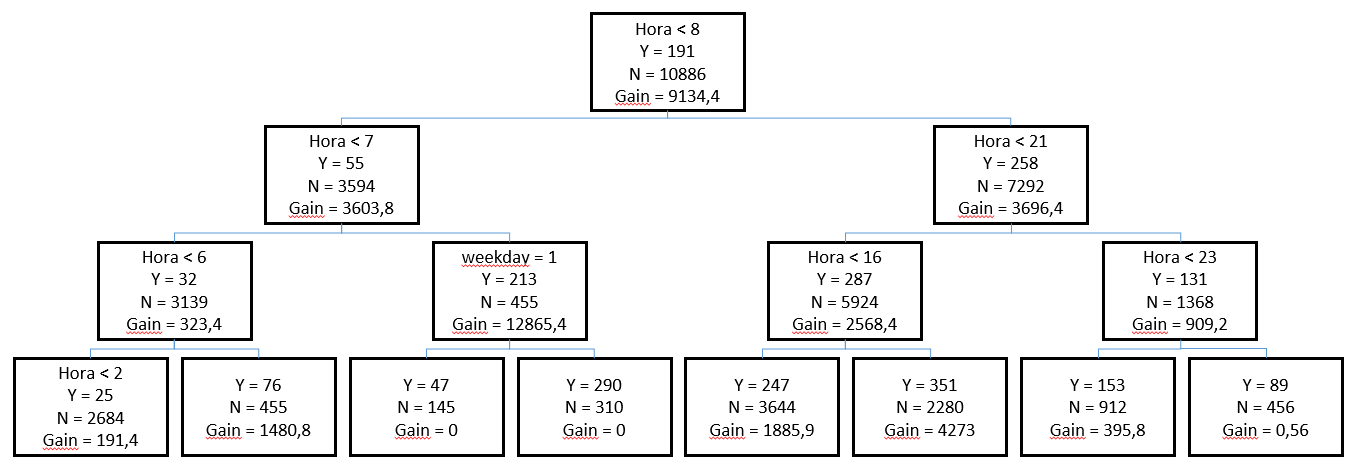

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

Text(0, 0.5, 'MSE')

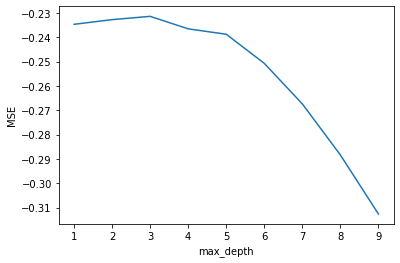

In [44]:
# Celda 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

max_depth_range = range(1, 10)
accuracy_scores = []

for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

In [13]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(-11494.611383354373, 7)

In [14]:
clf = DecisionTreeRegressor(max_depth=20, random_state=1)
clf.fit(X, y)
pd.DataFrame({'feature':["hour","workingday"], 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
1,workingday,0.18495
0,hour,0.81505


De manera similar a la regresión lineal la variable hora presenta una mayor importancia para explicar los cambios en la variable de alquiler, la facilidad de entrenar el modelo con la libreria permitio encontrar la profundidad optima para tener el menor MSE el cual requiere 7 niveles de profundidad, en comparación con el arbol creado manualmente de solo 4.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir la cantidad de reacciones en redes sociales (popularidad) de la notica. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [15]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [16]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [17]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [21]:
# Celda 6

max_depth_range = range(1, 21)
tree_score = []

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    tree_score.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
    
sorted(zip(tree_score, max_depth_range))[::-1][0]


(0.6353333333333333, 2)

In [45]:
models = {'lr': LogisticRegression(),
          'dc': DecisionTreeClassifier(max_depth=2, random_state=1)}

for model in models.keys():
    models[model].fit(X_train, y_train)
    
y_pred = pd.DataFrame(index= X_test.index, columns=models.keys())

for model in models.keys():
    y_pred[model] = models[model].predict(X_test)

for model in models.keys():
    print(model,f1_score(y_test, y_pred[model]),accuracy_score(y_test,y_pred[model]))

lr 0.61478163493841 0.6177777777777778
dc 0.6398659966499163 0.6416666666666667


La calibración del arbos se realiza mediante la profundidad de niveles esperados, arroja solo 2 niveles como el optimo el cual tiene un resultado ligeramente mejor que la regresión logistica en ambos parametros de evaluación, tanto el accuracy como el F1

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [72]:
# Celda 7

n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

clasif = {}
for i in range(n_estimators):
    if i < 100:
        clasif[i] = DecisionTreeClassifier(random_state=seeds[i])
        clasif[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    elif i < 200:
        clasif[i] = DecisionTreeClassifier(max_depth = 2, random_state=seeds[i])
        clasif[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    elif i < 300:
        clasif[i] = LogisticRegression(random_state=seeds[i])
        clasif[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])


In [73]:
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = clasif[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
4320,1,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2006,0,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5689,0,0,0,1,1,0,1,0,0,1,...,1,1,1,1,1,1,1,1,1,1
472,1,1,1,1,1,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
1370,1,0,0,1,1,1,1,0,0,1,...,1,1,1,1,1,1,1,1,1,1


In [74]:
y_pred_df.sum(axis=1)[:10]

4320     56
2006     75
5689    257
472     268
1370    245
1457    279
5783     31
3484    264
1145    265
130      48
dtype: int64

In [79]:
y_pred_mayo = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
mayo_score = f1_score(y_pred_mayo, y_test), accuracy_score(y_pred_mayo, y_test)
mayo_score

(0.6486187845303868, 0.6466666666666666)

En esta ocasión el desempeño global de los modelos presenta un mejor desempeño que los modelos en el punto anterior, dado que el caso anterior era solo una evaluación del modelo calibrado y en este punto se estan agregando modelos que iteran entre diferentes submuestreos que evitan el overfitting y presentan una menor variación.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [76]:
# Celda 8
samples_oob = []

for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
    
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = clasif[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    
alpha = (1 - errors) / (1 - errors).sum()

weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(20)

4320    0.177356
2006    0.240957
5689    0.864875
472     0.899259
1370    0.819619
1457    0.934519
5783    0.097539
3484    0.884385
1145    0.890039
130     0.151099
1136    0.882009
4658    0.325445
1161    0.842395
2152    0.466174
559     0.134914
916     0.047374
4278    0.091361
4394    0.148901
4008    0.133832
4910    0.927756
dtype: float64

In [80]:
y_pred_pond = (weighted_sum_1 >= 0.5).astype(np.int)
pond_score = f1_score(y_pred_pond, y_test), accuracy_score(y_pred_pond, y_test)
pond_score

(0.6485888212506918, 0.6472222222222223)

En esta ocasión los puntajes de calificación presentan una menor diferencia en comparación con el anterior punto mejorando el valor del accuracy y disminuyendo un poco el valor de f1, en este punto se ponderan los diferentes modelos segun su desempeño al predecir los valores de las muestras excluidas en el bagging

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

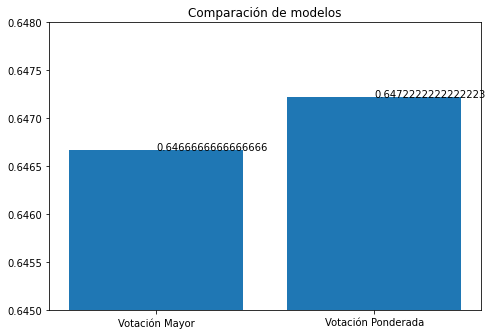

In [88]:
# Celda 9
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['Votación Mayor','Votación Ponderada']
ejeY = [mayo_score[1],pond_score[1]]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.ylim([0.645, 0.648])
plt.show()

En el punto 7 el ensamblaje usa como unico criterio la categoria con mas predicciones presente, sin embargo en la estructura del ejercicio se tienen igual cantidad de modelos calibrados, de clasificación y de regresion logistica por lo que un error en los dos modelos menos eficientes pueden afectar significativamente la prediccion del mejor modelo.

Esto trata de solventarse en el punto 8 donde se pondera cada modelo segun su eficiencia al predecir las muestras excluidas en el entrenamiento y se mejora el puntaje del accuracy, el cual relaciona la cantidad de predicciones correctas realizadas.